# Modeling
### goals
* get feature importances from grid search rather than random forest and try other model like SVR

## Import packages

In [145]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as sklearn_version
import datetime

import joblib

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

## Load X and y data sets

In [146]:
# import X and y training and test sets

X = pd.read_csv('../../data/train_test/X_alt')
y = pd.read_csv('../../data/train_test/y_alt')

X_train = pd.read_csv('../../data/train_test/X_train_74_26')

X_test = pd.read_csv('../../data/train_test/X_test_74_26')

y_train = pd.read_csv('../../data/train_test/y_train_alt_74_26')

y_test = pd.read_csv('../../data/train_test/y_test_alt+74_26')

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

In [148]:
svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

In [149]:
svr_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'scaler': StandardScaler(),
 'svr': SVR(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [150]:
epsilon = [round(n,5) for n in 3 * np.logspace(start=1, stop=-2, num=20)]
epsilon

[30.0,
 20.85578,
 14.49879,
 10.07945,
 7.00716,
 4.87133,
 3.38651,
 2.35428,
 1.63668,
 1.13781,
 0.791,
 0.54989,
 0.38228,
 0.26576,
 0.18475,
 0.12844,
 0.08929,
 0.06207,
 0.04315,
 0.03]

In [151]:
C = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
print(C)
svr_param_grid = {'scaler':[None, StandardScaler()],
                  'svr__C':C,
                  'svr__epsilon':epsilon
                  }

[10, 12, 16, 20, 26, 33, 42, 54, 69, 88, 112, 143, 183, 233, 297, 379, 483, 615, 784, 1000]


In [152]:
svr_grid = GridSearchCV(svr_pipe, param_grid=svr_param_grid, cv=5, n_jobs=-1)
svr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'scaler': [None, StandardScaler()],
                         'svr__C': [10, 12, 16, 20, 26, 33, 42, 54, 69, 88, 112,
                                    143, 183, 233, 297, 379, 483, 615, 784,
                                    1000],
                         'svr__epsilon': [30.0, 20.85578, 14.49879, 10.07945,
                                          7.00716, 4.87133, 3.38651, 2.35428,
                                          1.63668, 1.13781, 0.791, 0.54989,
                                          0.38228, 0.26576, 0.18475, 0.12844,
                                          0.08929, 0.06207, 0.04315, 0.03]})

In [153]:
svr_grid.best_params_

{'scaler': StandardScaler(), 'svr__C': 16, 'svr__epsilon': 1.13781}

In [154]:
svr_grid.best_score_

0.2003429300267626

In [155]:
svr_grid.score(X_test, y_test)

0.24680844128312762

In [156]:
svr_mean_score = svr_grid.cv_results_['mean_test_score']
svr_std_score = svr_grid.cv_results_['std_test_score']
C_vals = svr_grid.cv_results_['param_svr__C']
C_best =svr_grid.best_params_['svr__C']

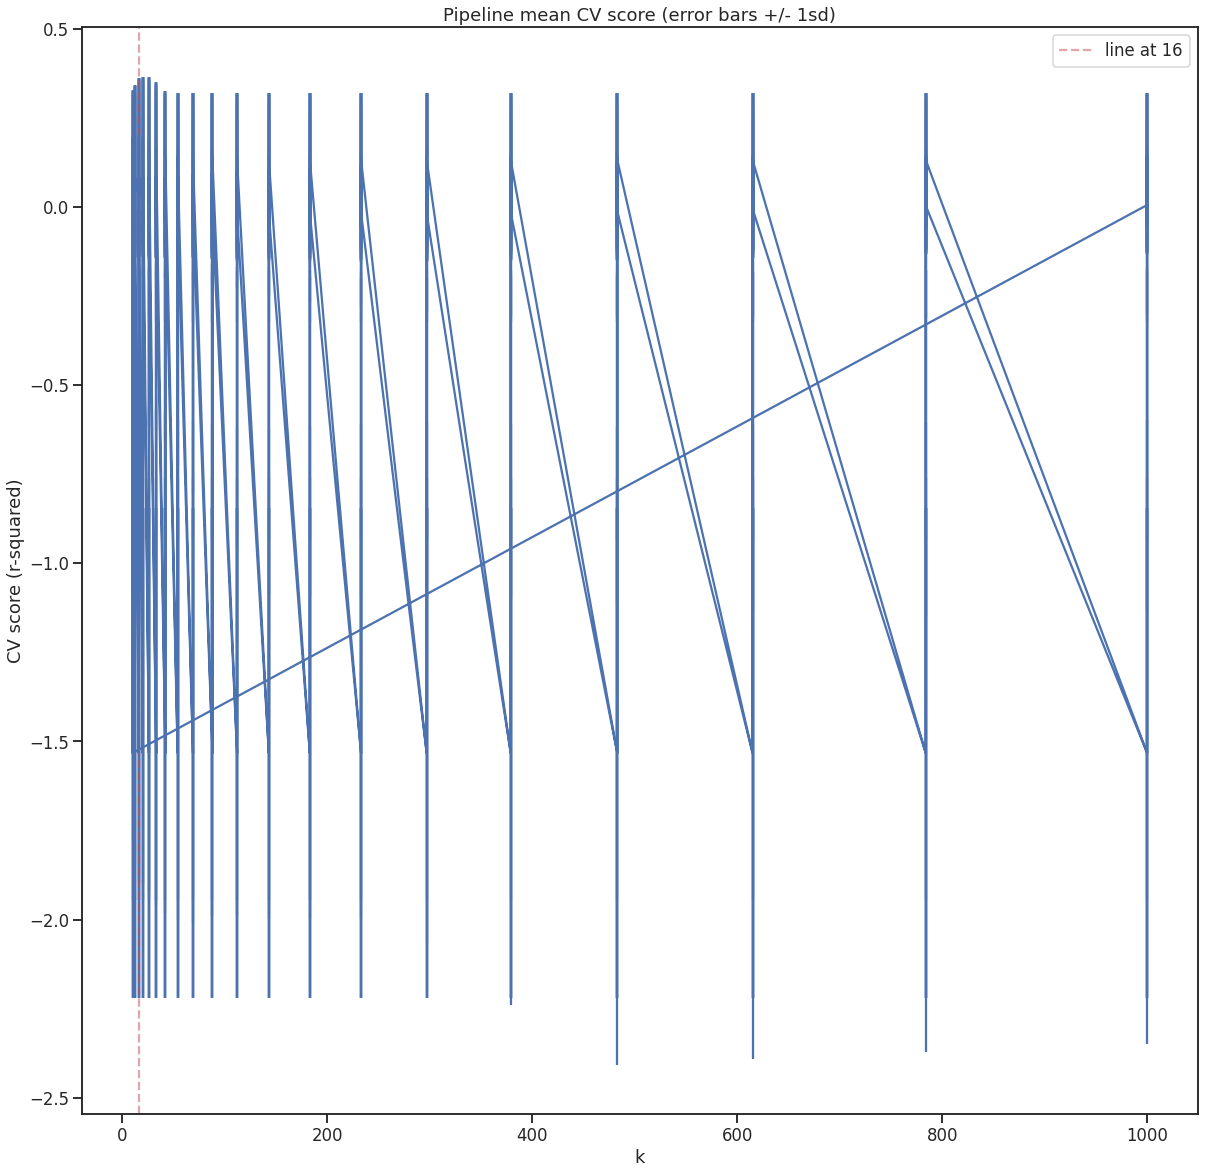

In [157]:
plt.subplots(figsize=(20, 20))
plt.errorbar(C_vals, svr_mean_score, yerr=svr_std_score)
plt.axvline(x=C_best, c='r', ls='--', alpha=.5, label='line at {}'.format(C_best))
# plt.xticks(np.arange(0,1300, step=50))
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

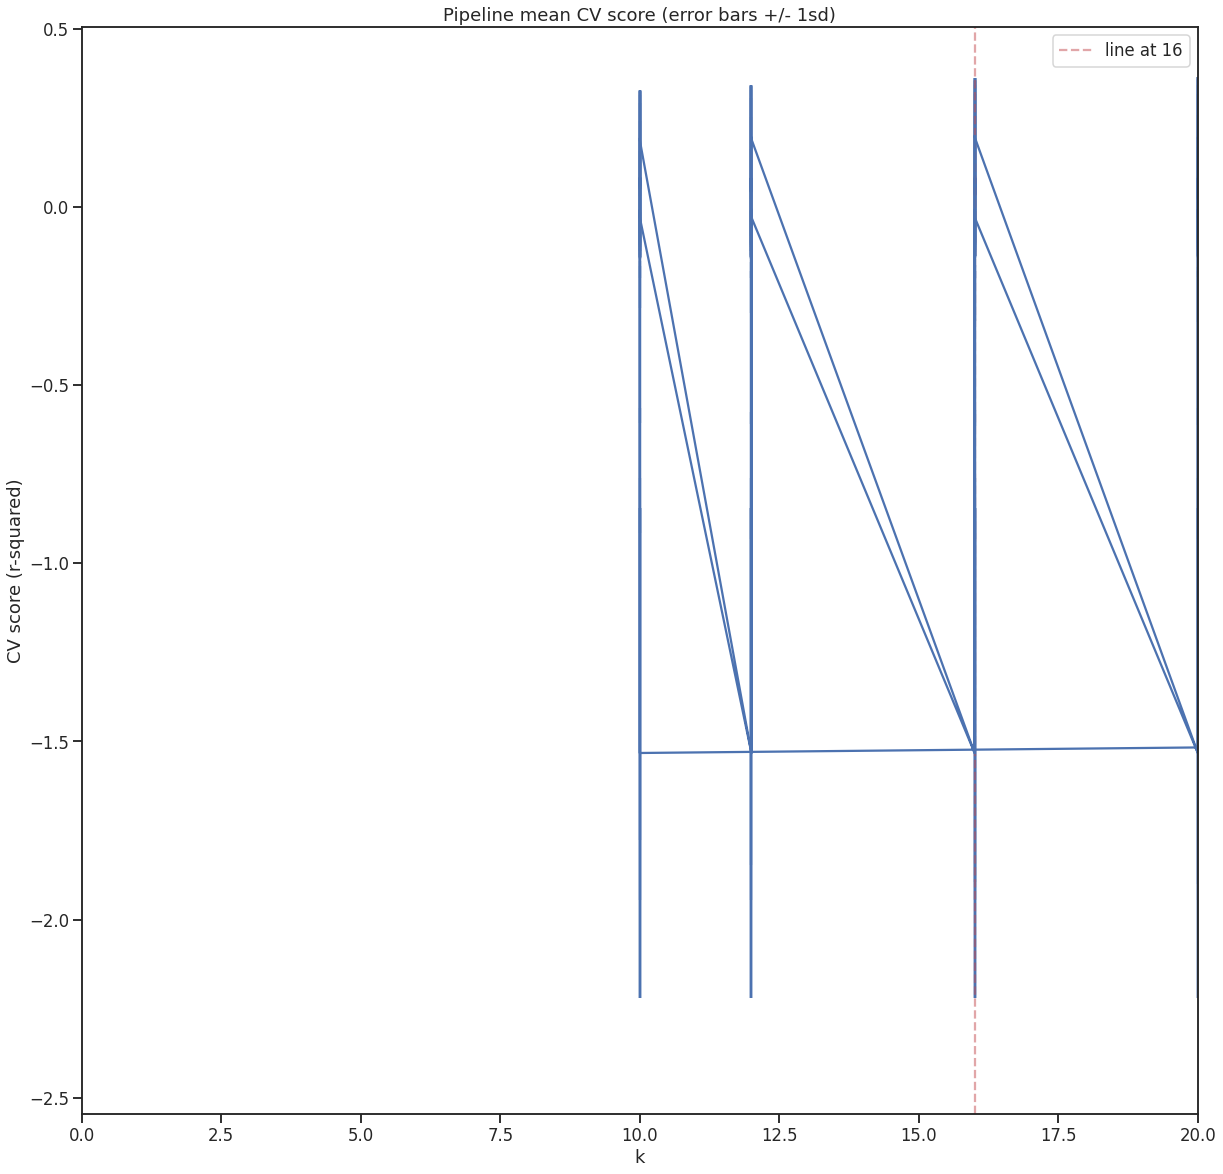

In [158]:
plt.subplots(figsize=(20, 20))
plt.errorbar(C_vals, svr_mean_score, yerr=svr_std_score)
plt.axvline(x=C_best, c='r', ls='--', alpha=.5, label='line at {}'.format(C_best))
# plt.xticks(np.arange(0,1300, step=50))
plt.xlim(0,20)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

try creeping it


In [159]:
C = [int(n) for n in np.logspace(start=4, stop=7, num=20)]
print(C)
svr_param_grid = {'svr__C':C,
                  'svr__epsilon':[0.1],
                  'scaler':[StandardScaler()]
                  }

[10000, 14384, 20691, 29763, 42813, 61584, 88586, 127427, 183298, 263665, 379269, 545559, 784759, 1128837, 1623776, 2335721, 3359818, 4832930, 6951927, 10000000]


In [160]:
svr_grid = GridSearchCV(svr_pipe, param_grid=svr_param_grid, cv=5, n_jobs=-1)
svr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler()],
                         'svr__C': [10000, 14384, 20691, 29763, 42813, 61584,
                                    88586, 127427, 183298, 263665, 379269,
                                    545559, 784759, 1128837, 1623776, 2335721,
                                    3359818, 4832930, 6951927, 10000000],
                         'svr__epsilon': [0.1]})

In [161]:
svr_grid.best_params_

{'scaler': StandardScaler(), 'svr__C': 10000, 'svr__epsilon': 0.1}

In [162]:
svr_grid.best_score_

0.13385021279249704

In [163]:
svr_grid.score(X_test, y_test)

0.19618628263194715

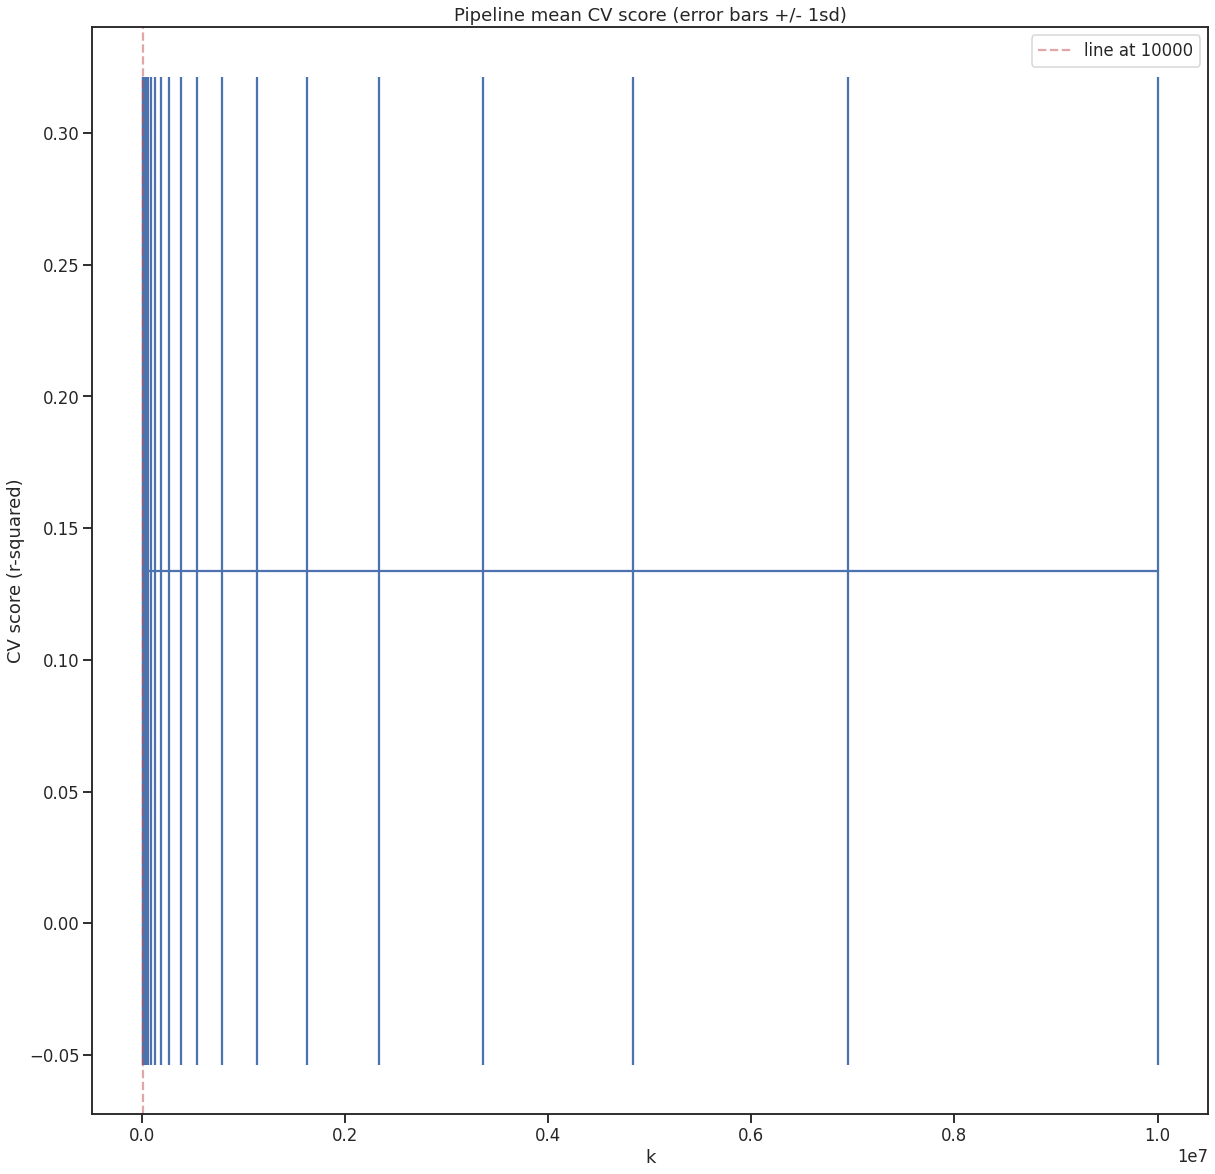

In [164]:
svr_mean_score = svr_grid.cv_results_['mean_test_score']
svr_std_score = svr_grid.cv_results_['std_test_score']
C_vals = svr_grid.cv_results_['param_svr__C']
C_best =svr_grid.best_params_['svr__C']


plt.subplots(figsize=(20, 20))
plt.errorbar(C_vals, svr_mean_score, yerr=svr_std_score)
plt.axvline(x=C_best, c='r', ls='--', alpha=.5, label='line at {}'.format(C_best))
# plt.xticks(np.arange(0,1300, step=50))
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

try diff svr kernel

In [165]:
epsilon = [round(n,5) for n in 3 * np.logspace(start=1, stop=-2, num=20)]
epsilon

[30.0,
 20.85578,
 14.49879,
 10.07945,
 7.00716,
 4.87133,
 3.38651,
 2.35428,
 1.63668,
 1.13781,
 0.791,
 0.54989,
 0.38228,
 0.26576,
 0.18475,
 0.12844,
 0.08929,
 0.06207,
 0.04315,
 0.03]

In [166]:
C = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
print(C)
svr_param_grid = {'scaler':[None, StandardScaler()],
                  'svr__kernel':['linear', 'rbf', 'poly'],
                  'svr__C':C,
                  'svr__epsilon':epsilon
                  }

[10, 12, 16, 20, 26, 33, 42, 54, 69, 88, 112, 143, 183, 233, 297, 379, 483, 615, 784, 1000]


In [ ]:
svr_grid_2 = GridSearchCV(svr_pipe, param_grid=svr_param_grid, cv=5, n_jobs=-1)
svr_grid_2.fit(X_train, y_train)

In [ ]:
svr_grid_2.best_params_

In [ ]:
svr_grid_2.best_score_

In [ ]:
svr_grid_2.score(X_test, y_test)